# Metodi di ricerca degli iperparametri

## **Grid Search**: 


metodo esaustivo brute force, definisco un insieme esaustivo di iperparametri, ogni combinazione verrà testata per la ricerca ottimale, testandole tutte trovo il vero ottimo tra i valori del sottoinsieme che sto testando. Molto time consuming e poco ottimizzato (non scalabile per tanti HP)

- selezione di valori in un range -> di solito scala logaritmica
- train per ogni combinazione possibile -> per tanti HP le combinazioni crescono exp
- validazione per ogni modello 
- scelto HP che danno validation test migliore (in base a metrica scelta)

<br>

- va bene per pochi HP
- trova migliore soluzione, no a compromessi
- scala come $O(n)^m$ con n possibili valori e m HP



## **Random Search**:


Algoritmo con performance uguali o superiori a GS anche per tanti HP. Valori estratti da distribuzione di probabilità definite in base alla natura degli HP che sto cercando

1. distribuzione di probabilità (bernoulli, multinomiale, discreta) in base a natura del problema
2. Tutti i valori hanno stessa prob di essere estratti -> riduzione del bias
3. più veloce -> non vengono testate tutte le combinazioni ma solo quelle randomicamente prese nella distribuzione di prob
    - non tutti gli HP hanno la stessa importanza nella variazione del validation test (importanti vs non importanti, definiti sulla base della variazione che apportano al Validation test)<br> <span style="color:red">Bergstra, James and Yoshua Bengio -  Random Search for hyperparameter optimization. - Journal of machine learning research 13.2(2012)</span> dimostrazione del perchè si trova randomicamente il valore ottimo e in modo più efficente rispetto il GS <br>
    - le possibili combinazioni, essendro randomiche e ugualmente probabili di essere selezionata, al crescere degli HP aumenta la probabilità di testare combinazioni in cui variano i parametri importanti. Copro meglio la probabilità dei parametri importanti.





## **Halving Random Search**

tecnica diversa nella gestione del dataset. Non cambia il tipo di algoritmo. 
Non uso tutto il dataset ma solo una porzione, quando trovo dei buoni HP (una buona combinazioni) le testo su tutto il dataset.

usata con la libreria sklearn


# Ottimizzazione degli iperparametri

parametri vs iperparametri del modello 
- <span style="color:red">parametri</span>:
    valori che il modello apprende durante il training del modello, trova i pesi che minimizzano la fase di loss (ovvero minimizzano l'errore del modello)
- <span style="color:green">iperparametri</span>: 
    fissati prima del training dallo sviluppatore (modello li usa nella sua fase di training)

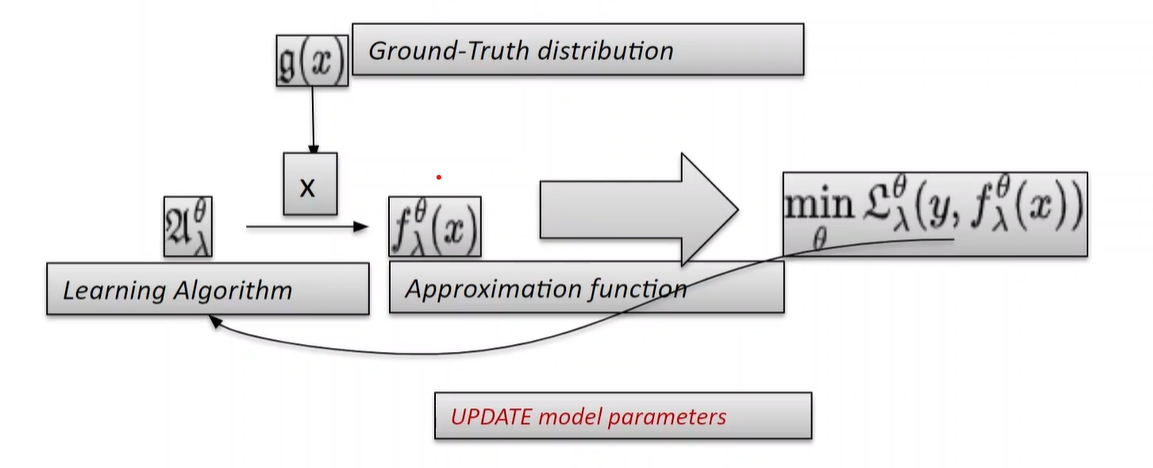

- Learning Algorithm = modello a cui viene fornita la *Ground truth distribution (GTD)* ovvero l'input (le X) e l'output desiderato (le label), tramite ciclo iterativo si cerca una funzione che meglio approssimi la GTD, ovvero la funzione cui pesi minimizzano la funzione di LOSS. 
- i parametri sono indicati con $\theta$ mentre gli iperparam con $\lambda$
- si fissano gli iperparamentri e con il training trovo i pesi ottimi rispetto gli HP definiti, variando gli HP potrei trovare nuovi pesi che minimizzano ulteriormente la loss

FINE TUNING = problema di ottimizzazione -> inner loop optimization problem 
1. fisso gli HP
2. faccio il train 
3. ho una loss (pf calcolate su evaluation Dataset)
4. nuovi HP e riparte il ciclo 

internamente calcolo i pesi, esternamente calcolo nuovi HP

in breve
1. FINE TUNING = problema di ottimizzazione 
2. come faccio FT se non conosco le label
3. non usare dataset di traing ma evaluation dataset -> altrimenti OVERFITTING!


## Tecniche per trovare evaluation dataset

### Hold out

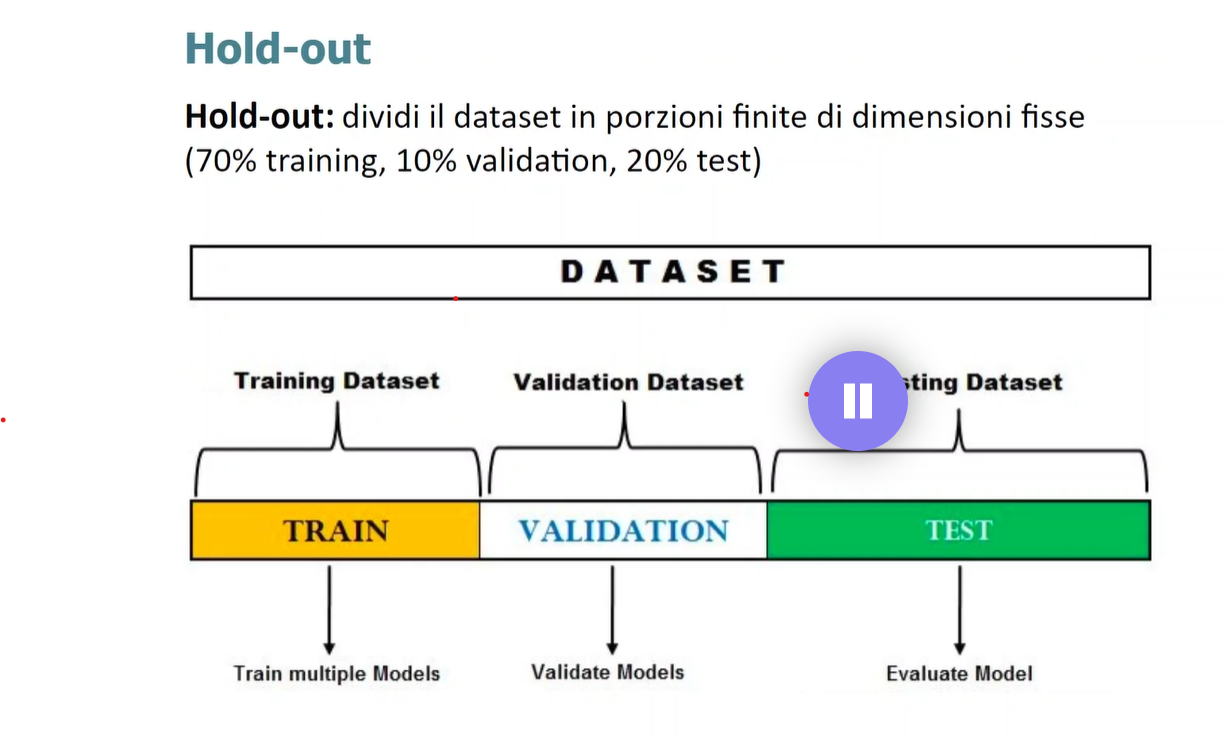

- 70% dati usati nel train
- 10% dei dati per validare il modello per capire validità degli HP
- quando sono soddisfatto e ho testato tutti i valori di HP, quindi quando ho un buon valore di LOSS nel train e nell'evaluation UNISCO il dataset di train e evaluation (80% dei dati), ritesto gli HP trovati e ritesto sul dataset di test
- le performance devono essere vicine

### k-fold cross validation

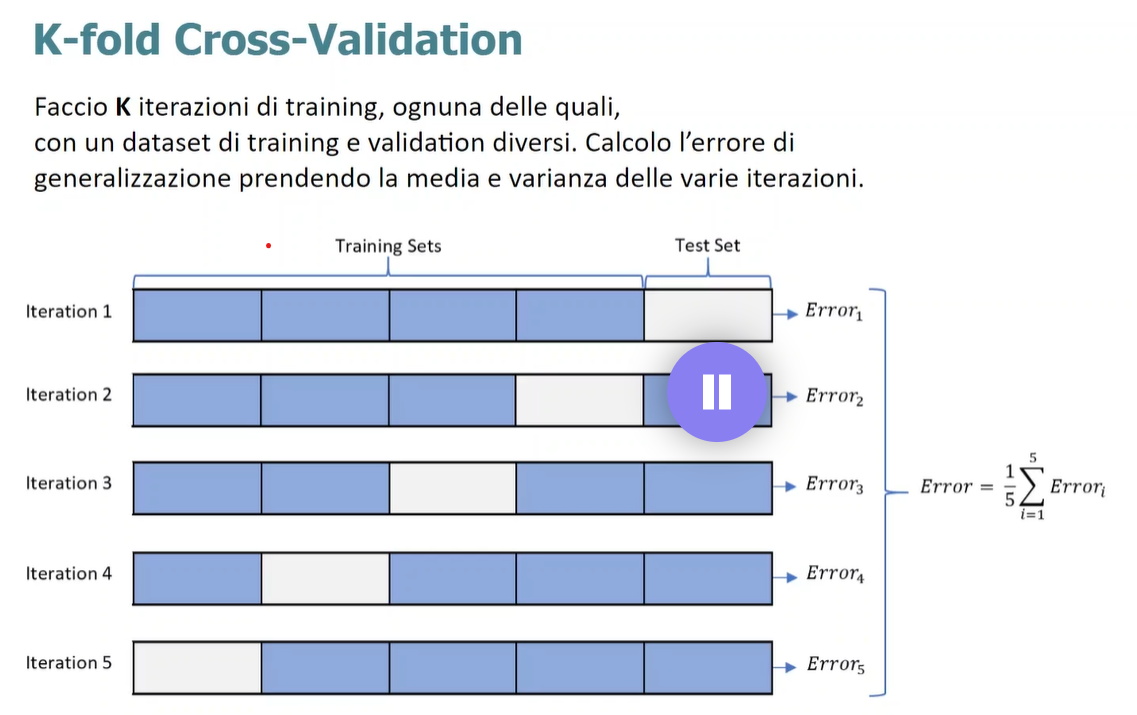

- con il **HOLD OUT** uso sempre stessi dati nel train
- con il k fold io testo su dati diversi, ogni iterazione diversa ha un training set e un validation set diverso evitando i problemi di bias dovuta a dati sempre uguali
- ISSUE: distribuzione delle label nei vari fold!!!, in un iterazione si vedono solo 4 label, mentre in un altra se ne vedono 5. risolvo con stratified cross validation

### Stratified cross validation

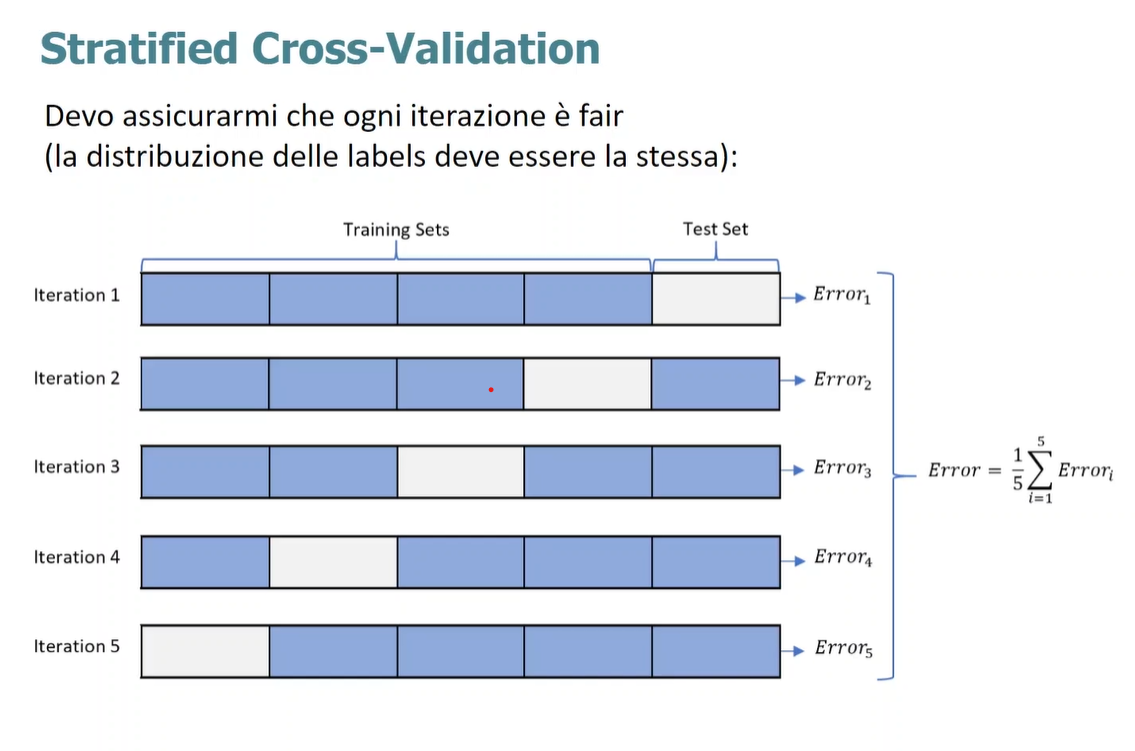

- come il k fold ma ha miglior gestione delle classi
- ogni esperimento ha lo stesso numero di label
- il validation error è fair

# Tuning iperparametri (code)

In [19]:
#utilities
import numpy as np
np.random.seed(1)
import pandas as pd
import matplotlib.pyplot as plt

#scipy and stats
import scipy
from scipy import stats

#scikit-learn
import sklearn

#preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

#feature selection
from sklearn.decomposition import PCA

#classification
from sklearn.linear_model import LogisticRegression

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

#pipeline
from sklearn.pipeline import make_pipeline

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [5]:
BASE_URL = r"https://raw.githubusercontent.com/ProfAi/machine-learning-avanzato/main/datasets/"

In [7]:
df = pd.read_csv(BASE_URL + "/breast_cancer.csv")
df.head()
df.describe()

,ID number,diagnosis,radius mean,texture mean,perimeter mean,area mean,smoothness mean,compactness mean,concavity mean,concave points mean,...,radius worst,texture worst,perimeter worst,area worst,smoothness worstse,compactness worst,concavity worst,concave points worst,symmetry worst,fractal dimension worst
0,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
1,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
2,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
3,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
4,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440


,ID number,radius mean,texture mean,perimeter mean,area mean,smoothness mean,compactness mean,concavity mean,concave points mean,symmetry mean,...,radius worst,texture worst,perimeter worst,area worst,smoothness worstse,compactness worst,concavity worst,concave points worst,symmetry worst,fractal dimension worst
count,5.630000e+02,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000,...,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000,563.000000
mean,2.908214e+07,14.128091,19.326590,91.968526,655.098046,0.096277,0.104178,0.088597,0.048834,0.181142,...,16.270726,25.736714,107.246963,880.639964,0.132316,0.254337,0.272225,0.114588,0.290112,0.083982
std,1.204239e+08,3.530133,4.280229,24.332321,352.779985,0.014097,0.052497,0.079480,0.038747,0.027333,...,4.834175,6.138410,33.554786,569.531967,0.022911,0.156850,0.208615,0.065670,0.061458,0.018057
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692210e+05,11.695000,16.210000,75.100000,420.050000,0.086025,0.064880,0.029320,0.020290,0.161950,...,13.010000,21.255000,84.095000,514.650000,0.116400,0.147450,0.115450,0.064955,0.250550,0.071465
50%,9.059780e+05,13.370000,18.890000,86.240000,551.100000,0.095780,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.450000,97.660000,686.500000,0.131300,0.214100,0.226700,0.099930,0.282200,0.080060
75%,8.836916e+06,15.780000,21.805000,103.950000,782.650000,0.105300,0.130450,0.130000,0.074020,0.195650,...,18.800000,29.880000,125.650000,1086.000000,0.146050,0.339500,0.384100,0.161950,0.317750,0.092085
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [9]:
X,y = df.iloc[:,2:].values, df.iloc[:,1].values
len(X), len(y)
y[0]

(563, 563)

'M'

In [11]:
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,stratify=y, random_state=1)
len(X_train), len(y_train)

(450, 450)

In [13]:
pipe_lr = make_pipeline(
    StandardScaler(),
    PCA(n_components=2),
    LogisticRegression()
)

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
test_acc = pipe_lr.score(X_test, y_test)
print(f"test accuracy: {test_acc:.3f}")

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregression', LogisticRegression())])

test accuracy: 0.965


## Grid Search (code)

il *param_grid* è una lista di dizionari che definisce il range di variazione dei parametri di addestramento per il Grid Search.
Nell'esempio gli si chiede di fare train con: 
- case1:
    1. svc__C che varia in param_range 
    2. svc__kernel di tipo 'linear'
- case2:
    1. svc__C che varia in param_range
    2. svc__kernel di tipo 'rbf'

verranno testate queste combinazioni nel GS


In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(
    StandardScaler(),
    SVC(random_state=1)
)

param_range = [0.0001, 0.001, 0.01, 0.1, 10.0, 100.0, 1000.0]

param_grid = [
    {'svc__C': param_range,
     'svc__kernel': ['linear']},
     {'svc__C': param_range,
      'svc__gamma' : param_range,
     'svc__kernel': ['rbf']}
]

grid = GridSearchCV(
    estimator=pipe_svc, #pipe svc definita prima
    param_grid=param_grid, #param grid definita sopra
    scoring='accuracy', #metrica di valutazione per gli HP in train
    cv=10, #numero di fold usati 
    refit=True, #riesegue il fit ogni nuovo fold
    n_jobs=1 #se >1 parallelizza il calcolo
)

gs = grid.fit(X_train, y_train)
gs.best_score_
gs.best_params_


0.9800000000000001

{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}

questi sono i migliori parametri rispetto alla griglia definita. Posso estrapolarli in un estimatore, che vado a rifittare sul train set e visualizzo accuracy sul test

In [17]:
clf = gs.best_estimator_
_ = clf.fit(X_train, y_train)
print(f"accuracy: {clf.score(X_test, y_test):.3f}")

accuracy: 0.956


## Random Search (code)

valori estratti da distribuzione uniforma (loguniform da 0.0001 a 1000.0)

In [23]:
from sklearn.model_selection import RandomizedSearchCV

In [20]:
param_range = scipy.stats.loguniform(0.0001, 1000.0)
param_range.rvs(10)

array([8.30145146e-02, 1.10222804e+01, 1.00184520e-04, 1.30715777e-02,
       1.06485687e-03, 4.42965766e-04, 2.01289666e-03, 2.62376594e-02,
       5.98924832e-02, 5.91176467e-01])

In [26]:
param_grid_rscv = [
    {'svc__C': param_range,
     'svc__kernel': ['linear']},
     {'svc__C': param_range,
      'svc__gamma' : param_range,
     'svc__kernel': ['rbf']}
]

rscv = RandomizedSearchCV(
    estimator=pipe_svc,
    param_distributions=param_grid_rscv,
    scoring='accuracy',
    cv=10,
    refit=True,
    random_state=1,
    n_iter=20,  # numero di iterazioni da fare
    n_jobs=1
)

In [27]:
rscv

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('svc', SVC(random_state=1))]),
                   n_iter=20, n_jobs=1,
                   param_distributions=[{'svc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x3118abb90>,
                                         'svc__kernel': ['linear']},
                                        {'svc__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x3118abb90>,
                                         'svc__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x3118abb90>,
                                         'svc__kernel': ['rbf']}],
                   random_state=1, scoring='accuracy')

In [28]:
_ = rscv.fit(X_train, y_train)
print(rscv.best_score_)
print(rscv.best_params_)

0.9755555555555556
{'svc__C': 0.05971247755848464, 'svc__kernel': 'linear'}


piu rapido del Grid search poichè non esaustivo

In [29]:
clf_rscv = rscv.best_estimator_
_ = clf_rscv.fit(X_train, y_train)
print(f"accuracy: {clf_rscv.score(X_test, y_test):.3f}")

accuracy: 1.000


## Halving random search (code)

In [38]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

hrs = HalvingRandomSearchCV(
    estimator=pipe_svc,
    param_distributions=param_grid,
    n_candidates='exhaust',
    # il numero di candidati da provare ad ogni iterazione
    # se impostato a 'exhaust' il numero di candidati
    # è pari al numero di combinazioni possibili
    # per i parametri definiti in param_grid
    # se il numero di candidati è 100, il primo step
    # avrà 100 candidati, il secondo step avrà 67 candidati,
    factor=1.5,  # fattore di riduzione del numero di candidati
    # ad ogni iterazione, quindi il numero di fold viene 
    # ridotto di un fattore pari a factor. In questo caso
    # il numero di fold viene ridotto di un fattore pari a 1.5
    # se il numero di fold è 10, il primo step avrà 10 fold,
    # il secondo step avrà 7 fold, ovvero 10/1.5
    random_state=1,
    n_jobs=1,
)

_ = hrs.fit(X_train, y_train)
print(hrs.best_score_)
print(hrs.best_params_)

0.9588235294117646
{'svc__kernel': 'linear', 'svc__C': 0.01}


# Auto ML Tuning: Flaml (code)

liberia os di Microsoft che permette, definito un dataset e il tipo di problema, Regressione o classificatore, di definire in maniera automatizzata miglior estimatore e fare anche tuning

In [39]:
!git clone https://github.com/gianpd/AML.git
!pip install -q scikit-plot

Clone in 'AML' in corso...
remote: Enumerating objects: 183, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 183 (delta 106), reused 123 (delta 54), pack-reused 0 (from 0)
Ricezione degli oggetti: 100% (183/183), 50.00 KiB | 1.19 MiB/s, fatto.
Risoluzione dei delta: 100% (106/106), fatto.


usiamo un vero dataset scaricato da kaggle, usando le api di kaggle <br>
dataset di aml in use casi di crypto

In [41]:
!pip install -q kaggle

-q riduce l’output a solo messaggi essenziali o di errore.

In [46]:
import json
import os

In [47]:
kaggle_file = '/Users/adanfindo/Desktop/proAiclone/Kaggle Settings.json'
with open(kaggle_file) as f:
    kaggle_cred = json.load(f)

In [48]:
os.environ['KAGGLE_USERNAME'] = kaggle_cred['username']
os.environ['KAGGLE_KEY'] = kaggle_cred['key']

!kaggle datasets download -d ellipticco/elliptic-data-set

Dataset URL: https://www.kaggle.com/datasets/ellipticco/elliptic-data-set
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
 99%|███████████████████████████████████████▍| 144M/146M [00:06<00:00, 30.6MB/s]
100%|████████████████████████████████████████| 146M/146M [00:06<00:00, 25.2MB/s]


creo una cartella **data** in cui unzippo il dataset

In [50]:
!mkdir data
!unzip -o elliptic-data-set.zip -d data

Archive:  elliptic-data-set.zip
  inflating: data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv  
  inflating: data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv  
  inflating: data/elliptic_bitcoin_dataset/elliptic_txs_features.csv  
